# Bitmap Graphics

In [1]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random
from time import time
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

#sns.set()
#sns.set_context('paper', font_scale=2.0)

-----

# A) Basic Shapes



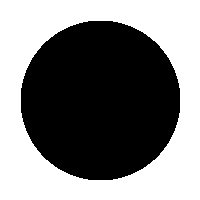

In [4]:
BLACK = (0, 0, 0)

def disc(r, size):
    im = Image.new('RGB', (size, size), color='white')
    mid = size / 2
    for x in range(size):
        for y in range(size):
            if (x-mid)**2 + (y-mid)**2 < r**2:
                im.putpixel((x, y), BLACK)
    return im

disc(r=80, size=200)

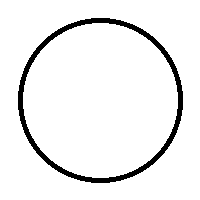

In [14]:
def circle(r, linewidth, size):
    mid = size / 2    
    def on_circle(x, y):
        return (
            (x-mid)**2 + (y-mid)**2 < (r+linewidth/2)**2
            and (x-mid)**2 + (y-mid)**2 > (r-linewidth/2)**2)

    im = Image.new('RGB', (size, size), color='white')
    for x in range(size):
        for y in range(size):
            if on_circle(x, y):
                im.putpixel((x, y), BLACK)
    return im

circle(r=80, linewidth=5, size=200)

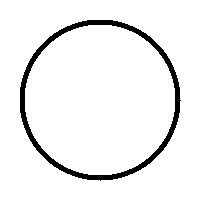

In [19]:
# In this function, I used different semantics of radius+linewidth
# - r is the outer radius.

def circle_parametric(r, linewidth, size):
    mid = size / 2 
    im = Image.new('RGB', (size, size), color='white')
    n_steps = 3 * 360  # TODO: Choose wrt. to r?
    for step in range(n_steps):
        alpha = 2 * pi * step / n_steps
        for radius in range(r - linewidth + 1, r+1):
            x = int(mid + radius * cos(alpha))
            y = int(mid + radius * sin(alpha))
            im.putpixel((x, y), BLACK)
    return im

circle_parametric(r=80, linewidth=5, size=200)

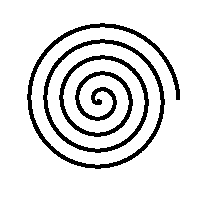

In [41]:
# TODO: color

def spiral(r, linewidth, n_turns, size):
    mid = size / 2 
    im = Image.new('RGB', (size, size), color='white')
    n_steps_per_turn = 3 * 360
    n_steps_total = n_steps_per_turn * n_turns
    for step in range(n_steps_total):
        alpha = 2 * pi * step / n_steps_per_turn
        spiral_radius = r * step / n_steps_total
        for k in range(linewidth):
            x = int(mid + (spiral_radius-k) * cos(alpha))
            y = int(mid + (spiral_radius-k) * sin(alpha))
            im.putpixel((x, y), BLACK)
    return im

spiral(r=80, linewidth=4, n_turns=5, size=200)

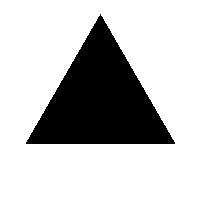

In [55]:
# TODO: vertikalni posunuti stale neni uplne sprave (viz side=200)

def triangle(side, size):
    mid = size / 2 
    im = Image.new('RGB', (size, size), color='white')
    def in_triangle(x, y):
        nx = x - mid
        ny = size - y - mid + (1/3) * side * sqrt(3)/2
        in_halfplane1 = ny <= -sqrt(3)*nx + side*sqrt(3)/2
        in_halfplane2 = ny <= sqrt(3)*nx + side*sqrt(3)/2
        in_halfplane3 = ny >= 0
        return in_halfplane1 and in_halfplane2 and in_halfplane3
    
    im = Image.new('RGB', (size, size), color='white')
    for x in range(size):
        for y in range(size):
            if in_triangle(x, y):
                im.putpixel((x, y), BLACK)
    return im

triangle(side=150, size=200)

In [58]:
# TODO: coloring

def ellipse(a, b, size):
    mid = size / 2 
    im = Image.new('RGB', (size, size), color='white')
    def in_ellipse(x, y):
        # TODO: use (x**2)/a, (y**2)/b, x*y/c
        pass
    
    im = Image.new('RGB', (size, size), color='white')
    for x in range(size):
        for y in range(size):
            if in_ellipse(x, y):
                im.putpixel((x, y), BLACK)
    return im

ellipse(side=150, size=200)

IndentationError: expected an indented block (<ipython-input-58-917643d82437>, line 9)

-----

# B) Polygon

How:
1) edges -> flood from a point -> possibly invert
2) for each line: color point based on even/odd number of intersections of semiline with edges (so no need to draw edges separately)

-----

# C) Effects